In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from random import choice,shuffle
from scipy import stats as st


from collections import deque

In [2]:
def gather_data(num_samples):
    
    global rock, paper, scissor, nothing

    cap = cv2.VideoCapture(0)

    # trigger tells us when to start recording
    trigger = False
    
    # Counter keeps count of the number of samples collected
    counter = 0
    
    # This the ROI size, the size of images saved will be box_size -10
    box_size = 234
    
    # Getting the width of the frame from the camera properties
    width = int(cap.get(3))


    while True:

        ret, frame = cap.read()
        
        # Flip the frame laterally
        frame = cv2.flip(frame, 1)
        
        if not ret:
            break
            
        if counter == num_samples:
            trigger = not trigger
            counter = 0
        
        # Define ROI for capturing samples
        cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
        
        # Make a resizable window.
        cv2.namedWindow("Collecting images", cv2.WINDOW_NORMAL)
        
        
        # If trigger is True than start capturing the samples
        if trigger:
            
            # Grab only slected roi
            roi = frame[5: box_size-5 , width-box_size + 5: width -5]
            
            eval(class_name).append([roi, class_name])
                                    
            counter += 1 

            text = "Collected Samples of {}: {}".format(class_name, counter)
            
        else:
            text = "Press 'r' to collect rock samples, 'p' for paper, 's' for scissor and 'n' for nothing"
        
        # Show the counter on the imaege
        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1, cv2.LINE_AA)
        
        cv2.imshow("Collecting images", frame)
        
        k = cv2.waitKey(1)
        
        # If user press 'r' than set the path for rock directoryq
        if k == ord('r'):
            
            trigger = not trigger
            class_name = 'rock'
            rock = []
            
        # If user press 'p' then class_name is set to paper and trigger set to True  
        if k == ord('p'):
            trigger = not trigger
            class_name = 'paper'
            paper = []
        
        # If user press 's' then class_name is set to scissor and trigger set to True  
        if k == ord('s'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []
                    
        # If user press 'n' then class_name is set to nothing and trigger set to True
        if k == ord('n'):
            trigger = not trigger
            class_name = 'nothing'
            nothing = []
        
        # Exit if user presses 'q'
        if k == ord('q'):
            break
            
    cam.release()
    cv2.destroyAllWindows()

In [3]:
no_of_samples = 100
gather_data(no_of_samples)
cam.release()

NameError: name 'cam' is not defined

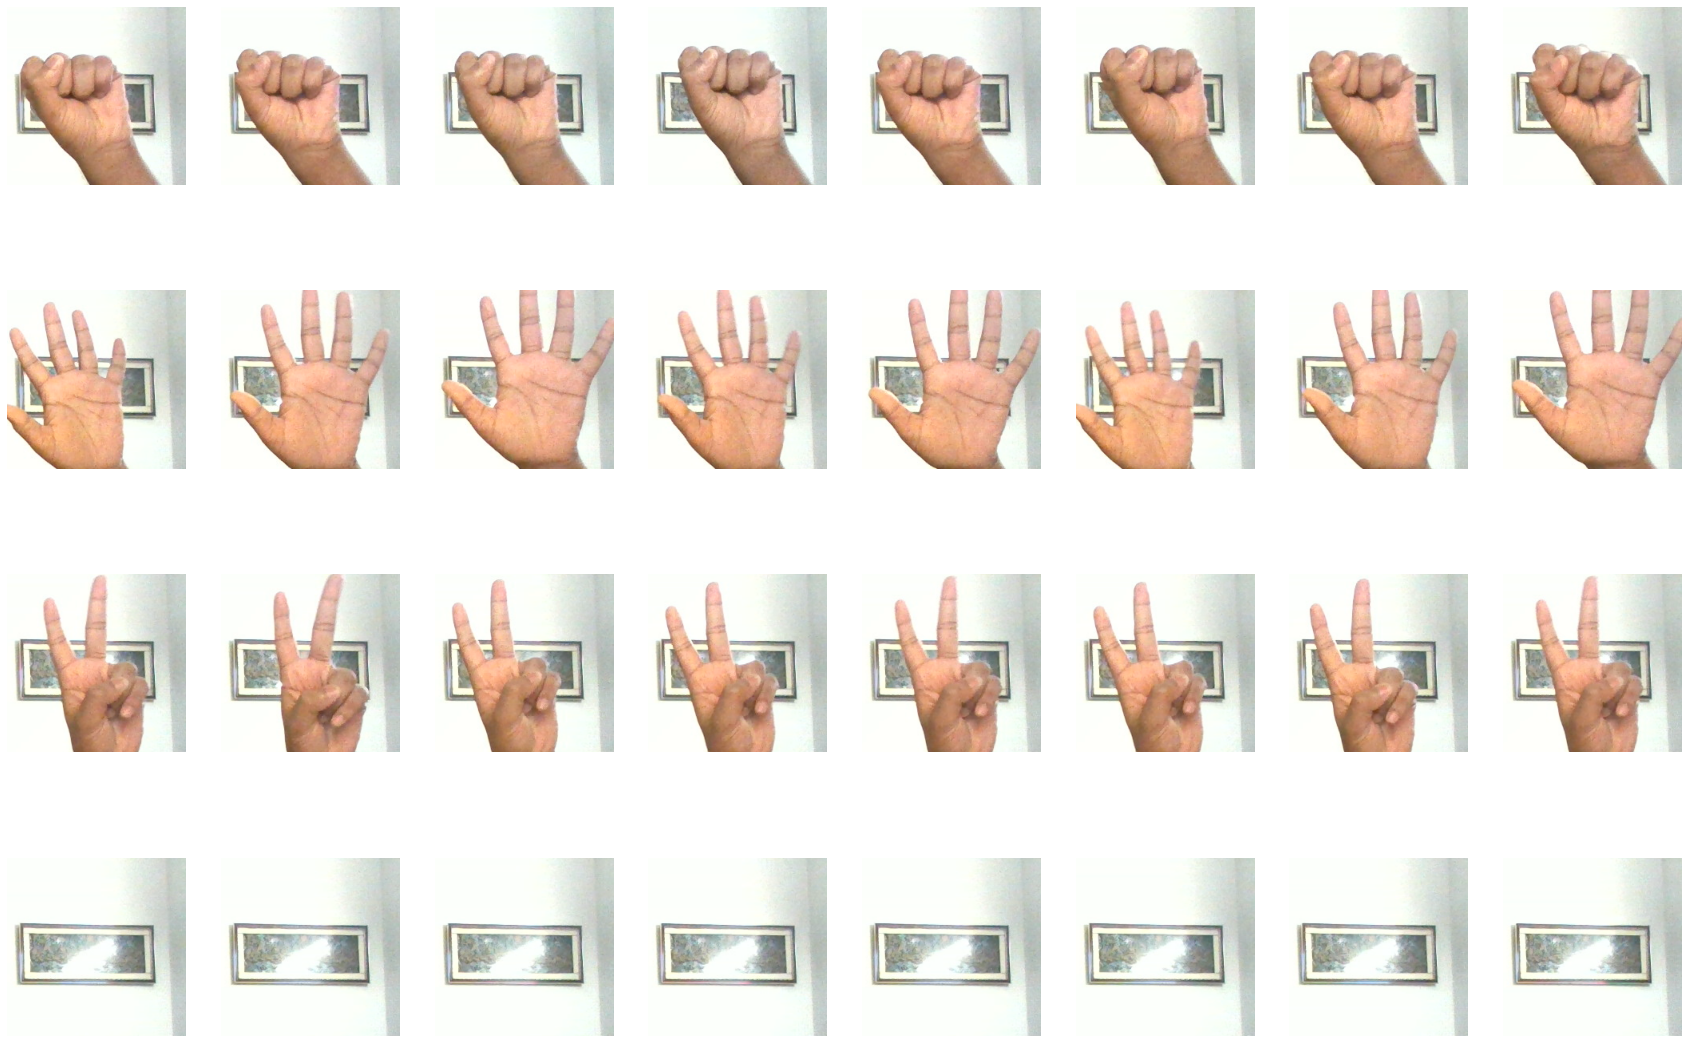

In [19]:
plt.figure(figsize=[30,20])

# Set the rows and columns
rows, cols = 4, 8

# Iterate for each class
for class_index, each_list in enumerate([rock, paper, scissor,nothing]):
    
    # Get 8 random indexes, since we will be showing 8 examples of each class.
    r = np.random.randint(no_of_samples, size=8);
    
    for i, example_index in enumerate(r,1):
        plt.subplot(rows,cols,class_index*cols + i );plt.imshow(each_list[example_index][0][:,:,::-1]);plt.axis('off');


In [20]:
rock [2][1]

'rock'

In [37]:
# Combine the labels and images of all classes together
labels = [tupl[1] for tupl in rock] + [tupl[1] for tupl in paper] + [tupl[1] for tupl in scissor] +[tupl[1] for tupl in nothing]

images = [tupl[0] for tupl in rock] + [tupl[0] for tupl in paper] + [tupl[0] for tupl in scissor] +[tupl[0] for tupl in nothing]

# Normalize the images by dividing by 255, now our images are in range 0-1. This will help in training.
images = np.array(images, dtype="float") / 255.0

print('Total images: {} , Total Labels: {}'.format(len(labels), len(images)))

encoder = LabelEncoder()

Int_labels = encoder.fit_transform(labels)

one_hot_labels = to_categorical(Int_labels, 4)

(trainX, testX, trainY, testY) = train_test_split(images, one_hot_labels, test_size=0.25, random_state=50)

images = []

Total images: 400 , Total Labels: 400


In [7]:
# This is the input size which our model accepts.
image_size = 224

# Loading pre-trained NASNETMobile Model without the head by doing include_top = False
N_mobile = tf.keras.applications.NASNetMobile( input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')

N_mobile.trainable = False    
x = N_mobile.output
x = GlobalAveragePooling2D()(x)
x = Dense(712, activation='relu')(x) 
x = Dropout(0.40)(x)
preds = Dense(4,activation='softmax')(x) 

model = Model(inputs=N_mobile.input, outputs=preds)

print ("Number of Layers in Model: {}".format(len(model.layers[:])))
model.summary()

Number of Layers in Model: 773
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_______________________________________________________________

separable_conv_2_normal_right2_ (None, 28, 28, 44)   2332        activation_66[0][0]              
__________________________________________________________________________________________________
separable_conv_2_normal_left5_3 (None, 28, 28, 44)   2332        activation_68[0][0]              
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 28, 28, 44)   176         separable_conv_2_normal_left1_3[0
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 28, 28, 44)   176         separable_conv_2_normal_right1_3[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 28, 28, 44)   176         separable_conv_2_normal_left2_3[0
__________________________________________________________________________________________________
separable_

__________________________________________________________________________________________________
adjust_conv_2_9 (Conv2D)        (None, 7, 7, 88)     46464       adjust_avg_pool_2_9[0][0]        
__________________________________________________________________________________________________
activation_140 (Activation)     (None, 7, 7, 704)    0           reduction_concat_reduce_8[0][0]  
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 7, 7, 176)    0           adjust_conv_1_9[0][0]            
                                                                 adjust_conv_2_9[0][0]            
__________________________________________________________________________________________________
normal_conv_1_9 (Conv2D)        (None, 7, 7, 176)    123904      activation_140[0][0]             
__________________________________________________________________________________________________
adjust_bn_

Total params: 5,025,152
Trainable params: 755,436
Non-trainable params: 4,269,716
__________________________________________________________________________________________________


In [8]:
augment = ImageDataGenerator( 
    
        rotation_range=30,
        zoom_range=0.25,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        horizontal_flip=False,
        fill_mode="nearest"
)

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
epochs = 15
batchsize = 20

history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
steps_per_epoch= len(trainX) // batchsize, epochs=epochs, verbose = 2)

Epoch 1/15
15/15 - 99s - loss: 0.9745 - accuracy: 0.6367 - val_loss: 0.3995 - val_accuracy: 1.0000
Epoch 2/15
15/15 - 29s - loss: 0.3858 - accuracy: 0.9533 - val_loss: 0.1379 - val_accuracy: 1.0000
Epoch 3/15
15/15 - 27s - loss: 0.1729 - accuracy: 0.9833 - val_loss: 0.0616 - val_accuracy: 1.0000
Epoch 4/15
15/15 - 27s - loss: 0.1149 - accuracy: 0.9867 - val_loss: 0.0408 - val_accuracy: 1.0000
Epoch 5/15
15/15 - 27s - loss: 0.0892 - accuracy: 0.9933 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 6/15
15/15 - 27s - loss: 0.0638 - accuracy: 0.9967 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 7/15
15/15 - 27s - loss: 0.0487 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 8/15
15/15 - 30s - loss: 0.0461 - accuracy: 0.9933 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 9/15
15/15 - 32s - loss: 0.0385 - accuracy: 0.9967 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 10/15
15/15 - 31s - loss: 0.0415 - accuracy: 0.9933 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 11/

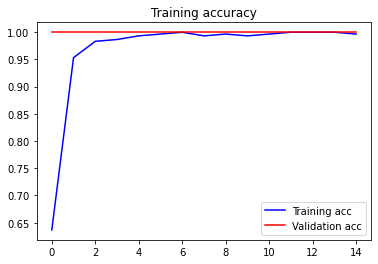

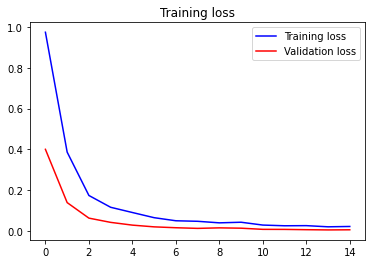

In [12]:
# Plot the accuracy and loss curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()


In [13]:
model.save("rps4.h5")

In [3]:
model = load_model("rps4.h5")

In [21]:
# This list will be used to map probabilities to class names, Label names are in alphabetical order.
label_names = ['nothing', 'paper', 'rock', 'scissor']

cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))

while True:
    
    ret, frame = cap.read()
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
           
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
        
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)

    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    
    roi = np.array([roi]).astype('float64') / 255.0
 
    # Get model's prediction.
    pred = model.predict(roi)
    
    target_index = np.argmax(pred[0])

    # Get the probability of the target class
    prob = np.max(pred[0])

    cv2.putText(frame, "prediction: {} {:.2f}%".format(label_names[np.argmax(pred[0])], prob*100 ),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
    
    cv2.imshow("Rock Paper Scissors", frame)
    
   
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [5]:
def findout_winner(user_move, Computer_move):
    
    if user_move == Computer_move:
        return "Tie"    
    
    elif user_move == "rock" and Computer_move == "scissor":
        return "User"
    
    elif user_move == "rock" and Computer_move == "paper":
        return "Computer"
    
    elif user_move == "scissor" and Computer_move == "rock":
        return "Computer"
    
    elif user_move == "scissor" and Computer_move == "paper":
        return "User"
    
    elif user_move == "paper" and Computer_move == "rock":
        return "User"
    
    elif user_move == "paper" and Computer_move == "scissor":
        return "Computer"

In [6]:
user_move = 'paper'
computer_move = choice(['rock', 'paper', 'scissor'])

winner = findout_winner(user_move, computer_move)

print("User Selected '{}' and computer selected '{}' , winner is: '{}' ".format(user_move, computer_move, winner))

User Selected 'paper' and computer selected 'paper' , winner is: 'Tie' 


In [7]:
user_move = 'paper'
computer_move = choice(['rock', 'paper', 'scissor'])

winner = findout_winner(user_move, computer_move)

print("User Selected '{}' and computer selected '{}' , winner is: '{}' ".format(user_move, computer_move, winner))

User Selected 'paper' and computer selected 'scissor' , winner is: 'Computer' 


In [8]:
def show_winner(user_socre, computer_score):    
    
    if user_score > computer_score:
        img = cv2.imread("images/youwin.jpg")
        
    elif user_score < computer_score:
        img = cv2.imread("images/comwins.jpg")
        
    else:
        img = cv2.imread("images/draw.jpg")
        
    cv2.putText(img, "Press 'ENTER' to play again, else exit",
                (150, 530), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
    
    cv2.imshow("Rock Paper Scissors", img)
    
    k = cv2.waitKey(0)
    
    if k == 13:
        return True

    else:
        return False

In [9]:
def display_computer_move(computer_move_name, frame):
    
    icon = cv2.imread( "images/{}.jpg".format(computer_move_name), 1)
    try: 
        icon = cv2.resize(icon, (224,224))
    
        # This is the portion which we are going to replace with the icon image
        roi = frame[0:224, 0:224]

        mask = icon[:,:,-1] 
        mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]
        icon_bgr = icon[:,:,:3] 
        img1_bg = cv2.bitwise_and(roi, roi, mask = cv2.bitwise_not(mask))
        img2_fg = cv2.bitwise_and(icon_bgr, icon_bgr, mask = mask)
        combined = cv2.add(img1_bg, img2_fg)
        frame[0:224, 0:224] = combined
    
    except Exception as e:
        print(str(e))

    return frame

In [22]:
cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))

# Specify the number of attempts you want. This means best of 5.
attempts = 5

# Initially the moves will be `nothing`
computer_move_name= "nothing"
final_user_move = "nothing"

label_names = ['nothing', 'paper', 'rock', 'scissor']

# All scores are 0 at the start.
computer_score, user_score = 0, 0

# The default color of bounding box is Blue
rect_color = (255, 0, 0)

# This variable remembers if the hand is inside the box or not.
hand_inside = False

total_attempts = attempts
confidence_threshold = 0.70
smooth_factor = 5
de = deque(['nothing'] * 5, maxlen=smooth_factor)

while True:
    
    ret, frame = cap.read()
    
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
           
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)

    # extract the region of image within the user rectangle
    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    
    roi = np.array([roi]).astype('float64') / 255.0
    
    # Predict the move made
    pred = model.predict(roi)
    move_code = np.argmax(pred[0])
    user_move = label_names[move_code]
    prob = np.max(pred[0])
    
    if prob >= confidence_threshold:
        

        de.appendleft(user_move)
        
        # Get the mode i.e. which class has occured more frequently in the last 5 moves.
        try:
            final_user_move = st.mode(de)[0][0] 
            
        except StatisticsError:
            print('Stats error')
            continue
        
        if final_user_move != "nothing" and hand_inside == False:
            
            hand_inside = True 
            
            # Get Computer's move and then get the winner.
            computer_move_name = choice(['rock', 'paper', 'scissor'])
            winner = findout_winner(final_user_move, computer_move_name)
            
            # Display the computer's move
            display_computer_move(computer_move_name, frame)
            
            # Subtract one attempt
            total_attempts -= 1
            
            if winner == "Computer":
                computer_score +=1
                rect_color = (0, 0, 255)

            elif winner == "User":
                user_score += 1;
                rect_color = (0, 250, 0)                
            
            elif winner == "Tie":
                rect_color = (255, 250, 255)
                
                
            # If all the attempts are up then find our the winner      
            if total_attempts == 0:
                
                play_again = show_winner(user_score, computer_score)
        
                if play_again:
                    user_score, computer_score, total_attempts = 0, 0, attempts
                
                # Otherwise quit the program.
                else:
                    break
        elif final_user_move != "nothing" and hand_inside == True:
            display_computer_move(computer_move_name, frame)
    
        # If class is nothing then hand_inside becomes False
        elif final_user_move == 'nothing':            
            hand_inside = False
            rect_color = (255, 0, 0) 

    cv2.putText(frame, "Your Move: " + final_user_move,
                    (420, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1, cv2.LINE_AA)

    cv2.putText(frame, "Computer's Move: " + computer_move_name,
                (2, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1, cv2.LINE_AA)

    cv2.putText(frame, "Your Score: " + str(user_score),
                    (420, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1, cv2.LINE_AA)
    cv2.putText(frame, "Computer Score: " + str(computer_score),
                    (2, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1, cv2.LINE_AA)
    
    cv2.putText(frame, "Attempts left: {}".format(total_attempts), (190, 400), cv2.FONT_HERSHEY_COMPLEX, 0.7,
                (100, 2, 255), 1, cv2.LINE_AA)    
    
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), rect_color, 2)
 
    cv2.imshow("Rock Paper Scissors", frame)

    # Exit if 'q' is pressed 
    k = cv2.waitKey(10)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()